# 基于RetinaFace实现人脸检测

## 模型简介

RetinaFace模型是一个非常有效的人脸检测模型，论文中使用WIDER FACE数据集对模型进行训练，最终在各种尺度上取得了比较好的人脸检测效果。

### 模型结构

![retinaface_structure](./picture/retinaface_structure.png)

RetinaFace网络的backbone可以是resnet模型，也可以替换为mobilenet模型，以便于进行实时检测。在backbone结构之后是一个FPN（Feature Pyramids Network）结构，可以更好的获取不同尺度下的特征以进行后续检测，并通过SSH（Single Stage Headless）加强特征的提取。

### 模型特点

1. RetinaFace网络本身可以同时检测人脸和脸部的5个关键点。
2. 模型采用了FPN，SSH，anchor等结构，可以检测不同尺度上的大小不同的人脸。

## 环境准备与数据获取

开始实验前，请配置好本地的MindSpore环境。

请从<>下载预训练模型和相关依赖代码。

### 数据集准备

请从WIDER FACE官网<https://shuoyang1213.me/WIDERFACE/index.html>下载完整的数据集。

请从RetinaFace仓库<https://github.com/biubug6/Pytorch_Retinaface>下载训练集和验证集的标签文件label.txt。

将解压后的数据集按照如下结构放置。

```text
.dataset/
    ├── ground_truth
    ├── train/
    |    ├──image/0--Parade
    |          ...
    └── val/
         └──image/0--Parade
               ...
.pretrained_model
.src
```

## 数据加载

通过create_dataset接口读取数据集，label.txt文件中保存着要读取的数据的地址以及标签值，如：box的坐标，landmark坐标等。

In [10]:
import mindspore as ms

from src.dataset import create_dataset

# 设定运行环境
ms.set_context(mode=ms.GRAPH_MODE,
               device_target='GPU',
               save_graphs=False,
               enable_graph_kernel=True,
               graph_kernel_flags="--enable_parallel_fusion")

# 加载数据集
batch_size = 1
ds_train = create_dataset(data_dir='./dataset/train/label.txt',
                          batch_size=batch_size,
                          multiprocessing=False,
                          num_worker=1)

### 数据可视化

WIDER FACE数据集是人脸检测的一个benchmark数据集，包含32203图像，以及393,703个标注人脸，其中，158,989个标注人脸位于训练集，39,,496个位于验证集。每一个子集都包含3个级别的检测难度：Easy，Medium，Hard。这些人脸在尺度，姿态，光照、表情、遮挡方面都有很大的变化范围。

下面就通过可视化代码来看一下数据集中的图片。

Image shape: (1, 3, 640, 640), Box label: [[[ 10.068302  135.75134     4.6087003   7.4990897]
  [  5.034151   67.87567     1.1429642   4.0333533]
  [  5.0683017 135.75134     4.6087003   7.4990897]
  ...
  [-11.16974    -7.867145  -12.719979   -9.82959  ]
  [-23.58948   -15.73429    -9.254243   -6.363854 ]
  [-11.79474    -7.867145  -12.719979   -9.82959  ]]], Class label: [[0 0 0 ... 0 0 0]], Land mark: [[[ -4.812584   123.88579      1.9787215  ... 138.60052      3.394012
   137.75137   ]
  [ -2.406292    61.942894     0.98936075 ...  69.30026      1.697006
    68.87569   ]
  [ -9.812584   123.88579     -3.0212784  ... 138.60052     -1.6059878
   137.75137   ]
  ...
  [-11.634768    -8.237944   -11.42254    ...  -7.7781076  -11.378311
    -7.804644  ]
  [-24.519535   -16.475887   -24.09508    ... -15.556215   -24.006622
   -15.609288  ]
  [-12.259768    -8.237944   -12.04754    ...  -7.7781076  -12.003311
    -7.804644  ]]]
Image shape: (1, 3, 640, 640), Box label: [[[  9.183848   126

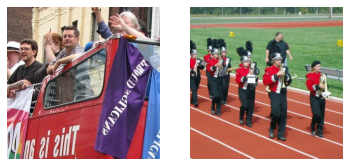

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 展示数据集中的两张图片
for i in range(2):
    example_image = next(ds_train.create_dict_iterator())
    images = example_image["image"].asnumpy()
    truths = example_image["truths"].asnumpy()
    conf = example_image["conf"].asnumpy()
    landm = example_image["landm"].asnumpy()

    # 展示图像的形状以及标签值
    print(f"Image shape: {images.shape}, "
          f"Box label: {truths}, "
          f"Class label: {conf}, "
          f"Land mark: {landm}")

    # 显示图片
    plt.subplot(1, 2, i+1)
    image_trans = np.transpose(images[0], (1, 2, 0))
    mean = np.array([104, 117, 123])
    image_trans = image_trans + mean
    image_trans = image_trans.astype(int)
    image_trans = image_trans[:, :, [2, 1, 0]]
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

## 模型解析

下面将通过代码来解析RetinaFace模型的核心结构。

### FPN结构

RetinaFace的backbone与其他网络类似，采用了特征提取效果比较好的resnet网络作为backbone。在应对实时检测问题上，将backbone换为轻量级的mobilenet网络也是业内常见的做法。

RetinaFace之所以能在多尺度上都获得比较好的检测效果，主要得益于FPN结构，下图就是FPN结构图[1]。

![FPN](./picture/FPN.png)

由图中的结构可以看出，P5是来自backbone深层的输出，代表着输入图像的全局特征（如：轮廓，形状等），P2是backbone浅层的输出，代表着输入图像的局部特征（如：纹理，角点等）。FPN的主要作用就是：

1. 通过上采样，将全局特征与局部特征进行融合，从而增强对目标的检测效果。
2. FPN结构中，不同层的输出也代表了不同尺度上的特征提取结果。

### SSH结构

![SSH](./picture/SSH.png)

SSH通过在特征图中引入上下文信息来提高小人脸的检测，这里的上下文主要指的是前后卷积的输出，将两个64channel和1个128channel的特征图进行融合，从而获取较好的上下文。

### anchor结构

目标检测一般都是采用anchor_based的方法，大致可以分为单阶段检测器和双阶段检测器。它们都是在一张图片上放置大量的预先定义好的 anchor boxes，然后预测其类别，优化这些anchor boxes的坐标，最终将这些优化后的 anchor boxes作为检测结果输出。本案例就是在单阶段检测器中应用anchor。

由于FPN和 Focal Loss 的出现，最近学术领域又开始关注在 anchor-free 检测器上。Anchor-free 检测器以两种不同的方式来直接找到物体，无需预先定义 anchors。一种方式是首先定位到多个预定义或自学习的关键点，然后约束物体的空间范围。作者称这种 anchor-free 方法为 keypoint-based 方法（基于关键点的方法）。另一种就是利用中心点或中心目标区域来定义正样本，然后预测它到目标四个边的距离。这类 anchor-free 方法被称作为 center-based 方法（基于中心点的方法）。这些 anchor-free 方法降低了有关anchor的超参数，取得的效果与 anchor-based 方法类似，使它们更具泛化潜能。

keypoint-based methods：这类 anchor-free 方法首先定位到预先定义或自学习的关键点，然后生成边框来检测物体。CornerNet 通过一对关键点（左上角和右下角）来检测物体的边框，CornerNet-Lite 引入了 CornerNet-Saccade 和 CornerNet-Squeeze 来提升其速度。Grid R-CNN 的第二个阶段利用FCN的位置敏感的优点来预测网格点，然后再判断边框、定位物体。ExtremeNet 检测物体的4个点（最上面、最左面、最下面、最右面）以及一个中心点来生成物体的边框。Zhu 等人利用关键点估计来找到物体的中心点，然后回归出其他的属性，包括大小、三维位置、朝向、姿态等。CenterNet 扩展了CornerNet，通过三个点而不是两个点来提升精度和召回率。RepPoints 将物体表示为一个样本点的集合，通过约束物体的空间范围、强调语义重要的局部区域来学习。

Center-based methods：这类方法将物体的中心区域（中心点或区域）看作为前景，定义正样本，然后预测它到物体四个边的距离。YOLO 将图像分割为S×S个网格，如果物体的中心点落在了某网格内，该网格就要负责检测该目标物体。DenseBox 利用物体中心位置的圆圈区域来定义正样本，然后预测该圆圈到物体边界的四个距离。GA-RPN 将物体中心区域的像素点定义为正样本，为 Faster R-CNN 预测物体候选框的位置、宽度和高度。FSAF 在 RetinaNet 之上加了一个 anchor-free 的分支和在线特征选取机制，这个分支将物体的中心区域定义为正样本，利用它到物体的四个边的距离来定位它。FCOS 将物体边框内的所有位置都定义为正样本，然后通过4个距离值和1个 centerness 分数来检测物体。CSP 只将物体的中心点定义为正样本，通过固定的 aspect ratio 来检测行人。FoveaBox 将物体的中间部分位置定义为正样本，每个位置有4个距离来进行检测。

本文使用了keypoint-based的方法，对于输入的640*640的图像缩放到80*80，40*40，20*20三个尺度，同时在缩放后的每个特征图上生成2个不同大小的正方形anchor用于目标检测。从下列代码中，可以看到anchor的生成方法。

In [3]:
# image_sizes代表了输入图像的尺寸，min_sizes规范了anchor框的宽和高
# step与image_sizes配合计算缩放后的特征图尺寸，clip用于限定输出anchor的值在（0，1）内
def prior_box(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    # 对于每一个缩放后的特征图，其每一个点代表了原图中的一个区域，因此，以缩放后的特征图点创建anchor框
    # 就可以以映射原图中的一个较大区域，从而实现人脸检测
    anchors = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4]).astype(np.float32)

    if clip:
        output = np.clip(output, 0, 1)

    return output

### 网络输出

基础的RetinaFace网络的输出由三部分组成。

![retinaface_output](./picture/retinaface_output.png)

由网络结构图可以看出，RetinaFace网络输出三个部分的内容：Face Classification，Face box regression, Facial landmark regression。如果以输入图像是640*640的图片为例。

Face Classification的输出是一个形如（1，16800，2）的矩阵，代表了所有anchor位置是否存在人脸。

Face box regression的输出是一个形如（1，16800，4）的矩阵，代表了所有anchor位置坐标点的回归值，通过对该值的处理可或得该区域的box坐标值。综合Face Classification的输出就可以筛选出最终的人脸框。

Facial landmark regression的输出是一个形如（1，16800，10）的矩阵，代表了每个anchor位置landmark点的回归值。由于WIDER FACE数据集给予每张人脸5个关键点的标注，所以最终的维度是10。

## 模型训练

模型训练前需要定义好优化器，损失函数等。同时，可以加载预训练模型以加快模型训练。本案例中，为了方便展示效果，选取了数据集中的部分数据进行了10个epoch的训练，由于加载了与训练模型，所以loss值趋于稳定，在20-30间波动，这可以作为判断模型收敛的一个标准。

训练得到的ckpt文件被保存在checkpoint文件夹内，可以作为后续finetune以及推理的加载模型使用。

In [5]:
import math

from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

from src.loss import MultiBoxLoss
from src.network import RetinaFace, RetinaFaceWithLossCell, TrainingWrapper
from src.lr_schedule import adjust_learning_rate

# 定义相关超参数
steps_per_epoch = math.ceil(ds_train.get_dataset_size())

# 定义损失函数，由于RetinaFace网络输出三部分的内容（类别，box坐标，landmark坐标）
# 所以它的损失值要综合三个部分的损失来计算
multibox_loss = MultiBoxLoss(num_classes=2, num_boxes=16800, neg_pre_positive=7, batch_size=batch_size)

# 初始化网络
net = RetinaFace(phase='train', backbone='mobilenet25')
net.set_train(True)

# 加载预训练模型
pretrain_model_path = './pretrained_model/MobilenetRetinaFace_1-92_1609.ckpt'
param_dict_retinaface = ms.load_checkpoint(pretrain_model_path)
ms.load_param_into_net(net, param_dict_retinaface)
print('Resume Model Done.')

# 集成损失函数
net = RetinaFaceWithLossCell(net, multibox_loss)

# 定义优化器
lr = adjust_learning_rate(initial_lr=0.01,
                          gamma=0.1,
                          stepvalues=(70, 90),
                          steps_pre_epoch=steps_per_epoch,
                          total_epochs=100,
                          warmup_epoch=5)
opt = ms.nn.SGD(params=net.trainable_params(),
                learning_rate=lr,
                momentum=0.9,
                weight_decay=5e-4,
                loss_scale=1)

# 对损失函数，优化器和网络进行编译
net = TrainingWrapper(net, opt)
model = Model(net)

# 设定网络训练时的回调函数，主要用于保存ckpt文件和计算运行时间
config_ck = CheckpointConfig(save_checkpoint_steps=2000,
                             keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix="RetinaFace", directory='./checkpoint/', config=config_ck)

time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
callback_list = [LossMonitor(), time_cb, ckpoint_cb]

# 开始训练
print("============== Starting Training ==============")
model.train(10, ds_train, callbacks=callback_list,
            dataset_sink_mode=True)

[WARNING] ME(121193:140546156214080,MainProcess):2022-06-14-22:27:04.751.838 [mindspore/train/serialization.py:660] For 'load_param_into_net', remove parameter network.base.stage1.0.0.weight's prefix name: network., continue to load it to net parameter base.stage1.0.0.weight.


Resume Model Done.
============== Starting Training ==============
epoch: 1 step: 19, loss is 11.86143684387207
epoch time: 11655.648 ms, per step time: 613.455 ms
epoch: 2 step: 19, loss is 31.659400939941406
epoch time: 1079.620 ms, per step time: 56.822 ms
epoch: 3 step: 19, loss is 24.292753219604492
epoch time: 1061.935 ms, per step time: 55.891 ms
epoch: 4 step: 19, loss is 32.195228576660156
epoch time: 1125.007 ms, per step time: 59.211 ms
epoch: 5 step: 19, loss is 21.058605194091797
epoch time: 1130.897 ms, per step time: 59.521 ms
epoch: 6 step: 19, loss is 21.991657257080078
epoch time: 1132.218 ms, per step time: 59.590 ms
epoch: 7 step: 19, loss is 21.44530487060547
epoch time: 1121.750 ms, per step time: 59.039 ms
epoch: 8 step: 19, loss is 28.60151481628418
epoch time: 1175.555 ms, per step time: 61.871 ms
epoch: 9 step: 19, loss is 21.299671173095703
epoch time: 1181.396 ms, per step time: 62.179 ms
epoch: 10 step: 19, loss is 26.33272361755371
epoch time: 1072.464 ms,

## 模型验证

模型的验证同样使用WIDER FACE数据集。前文有提到WIDER FACE数据集的每一个检测子集都包含了三个难度：Easy，Medium，Hard。

Easy代表图片中的人脸区域较大，人脸数量不多，相对容易检测。

Medium代表图片中的人脸区域适中，人脸数量较Easy难度要多。

Hard代表图片中人脸区域较小，甚至有重叠，人脸数量很多。

因此，将在验证集上对三个难度的数据进行验证，分别输出其AP值（AP是precision指标与recall指标构成的PR曲线的面积，指标越接近1，证明效果越好。）

### 加载模型

In [6]:
from src.utils import Timer, prior_box
from src.detection import DetectionEngine
from src.network import RetinaFace

# 定义验证集路径及相关超参数
testset_folder = "./dataset/val"
testset_label_path = "./dataset/val/label.txt"
target_size = 640
max_size = 640

# 加载验证集，获取验证集所有图片的路径
with open(testset_label_path, 'r') as f:
    _test_dataset = f.readlines()
    test_dataset = []
    for im_path in _test_dataset:
        if im_path.startswith('# '):
            test_dataset.append(im_path[2:-1])

num_images = len(test_dataset)

# 实例化timer用于计时
timers = {'forward_time': Timer(), 'misc': Timer()}

# 生成anchor
priors = prior_box(image_sizes=(max_size, max_size),
                   min_sizes=[[16, 32], [64, 128], [256, 512]],
                   steps=[8, 16, 32],
                   clip=False)

# 实例化检测方法，主要用于对输出结果进行解析，保存检测结果
detection = DetectionEngine()

net = RetinaFace(phase='predict', backbone='mobilenet25')
net.set_train(False)

# 加载预训练模型
pretrain_model_path = './pretrained_model/MobilenetRetinaFace_1-92_1609.ckpt'
param_dict_retinaface = ms.load_checkpoint(pretrain_model_path)
ms.load_param_into_net(net, param_dict_retinaface)
print('Resume Model Done.')


[WARNING] ME(121193:140546156214080,MainProcess):2022-06-14-22:27:31.249.790 [mindspore/train/serialization.py:660] For 'load_param_into_net', remove parameter network.base.stage1.0.0.weight's prefix name: network., continue to load it to net parameter base.stage1.0.0.weight.


Resume Model Done.


### 验证

通过处理所有的验证集图片，获取其人脸box位置，landmark位置与标签值进行对比获取评价指标。

In [7]:
import os
import cv2
import numpy as np

from mindspore import Tensor

print('Predict box starting')
for i, img_name in enumerate(test_dataset):

    # 读取图片
    image_path = os.path.join(testset_folder, 'images', img_name)
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = np.float32(img_raw)

    # 获取图片尺寸，计算resize的比例系数
    im_size_min = np.min(img.shape[0:2])
    im_size_max = np.max(img.shape[0:2])
    resize = float(target_size) / float(im_size_min)

    # 以图片较长的边进行resize，规范化图片尺寸
    if np.round(resize * im_size_max) > max_size:
        resize = float(max_size) / float(im_size_max)
    img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
    assert img.shape[0] <= max_size and img.shape[1] <= max_size

    # 以固定数值填充图像，补充成640*640的正方形图像
    image_t = np.empty((max_size, max_size, 3), dtype=img.dtype)
    image_t[:, :] = (104.0, 117.0, 123.0)
    image_t[0:img.shape[0], 0:img.shape[1]] = img
    img = image_t

    # 实例化解码模型输出时需要的参数
    scale = np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)
    ldm_scale = np.array(
        [img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1],
         img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)

    # 数据预处理
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = Tensor(img)  # [1, c, h, w]

    # 模型验证
    timers['forward_time'].start()
    boxes, confs, ldm = net(img)
    timers['forward_time'].end()

    # 模型输出解码，将输出的三个矩阵解码为最终的结果
    # box的坐标，以及landmark的坐标值
    timers['misc'].start()
    detection.detect(boxes, ldm, confs, resize, scale, ldm_scale, img_name, priors)
    timers['misc'].end()

    print('im_detect: {:d}/{:d} forward_pass_time: {:.4f}s misc: {:.4f}s'.format(i + 1, num_images,
                                                                                 timers['forward_time'].diff,
                                                                                 timers['misc'].diff))
print('Predict box done.')
print('Eval starting')


# Save the predict result if you want.
predict_result_path = detection.write_result()
print('predict result path is {}'.format(predict_result_path))

detection.get_eval_result()
print('Eval done.')

Predict box starting
im_detect: 1/3226 forward_pass_time: 1.5610s misc: 0.0054s
im_detect: 2/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 3/3226 forward_pass_time: 0.0108s misc: 0.0064s
im_detect: 4/3226 forward_pass_time: 0.0109s misc: 0.0051s
im_detect: 5/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 6/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 7/3226 forward_pass_time: 0.0108s misc: 0.0077s
im_detect: 8/3226 forward_pass_time: 0.0108s misc: 0.0055s
im_detect: 9/3226 forward_pass_time: 0.0106s misc: 0.0054s
im_detect: 10/3226 forward_pass_time: 0.0109s misc: 0.0049s
im_detect: 11/3226 forward_pass_time: 0.0107s misc: 0.0049s
im_detect: 12/3226 forward_pass_time: 0.0107s misc: 0.0051s
im_detect: 13/3226 forward_pass_time: 0.0108s misc: 0.0072s
im_detect: 14/3226 forward_pass_time: 0.0109s misc: 0.0051s
im_detect: 15/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 16/3226 forward_pass_time: 0.0107s misc: 0.0071s
im_detect: 17/3226 forward_p

im_detect: 141/3226 forward_pass_time: 0.0114s misc: 0.0057s
im_detect: 142/3226 forward_pass_time: 0.0110s misc: 0.0059s
im_detect: 143/3226 forward_pass_time: 0.0115s misc: 0.0054s
im_detect: 144/3226 forward_pass_time: 0.0109s misc: 0.0064s
im_detect: 145/3226 forward_pass_time: 0.0113s misc: 0.0073s
im_detect: 146/3226 forward_pass_time: 0.0110s misc: 0.0076s
im_detect: 147/3226 forward_pass_time: 0.0112s misc: 0.0061s
im_detect: 148/3226 forward_pass_time: 0.0105s misc: 0.0053s
im_detect: 149/3226 forward_pass_time: 0.0106s misc: 0.0051s
im_detect: 150/3226 forward_pass_time: 0.0104s misc: 0.0054s
im_detect: 151/3226 forward_pass_time: 0.0104s misc: 0.0051s
im_detect: 152/3226 forward_pass_time: 0.0104s misc: 0.0064s
im_detect: 153/3226 forward_pass_time: 0.0110s misc: 0.0061s
im_detect: 154/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detect: 155/3226 forward_pass_time: 0.0105s misc: 0.0052s
im_detect: 156/3226 forward_pass_time: 0.0105s misc: 0.0054s
im_detect: 157/3226 forw

im_detect: 279/3226 forward_pass_time: 0.0123s misc: 0.0072s
im_detect: 280/3226 forward_pass_time: 0.0118s misc: 0.0064s
im_detect: 281/3226 forward_pass_time: 0.0118s misc: 0.0060s
im_detect: 282/3226 forward_pass_time: 0.0111s misc: 0.0051s
im_detect: 283/3226 forward_pass_time: 0.0110s misc: 0.0053s
im_detect: 284/3226 forward_pass_time: 0.0112s misc: 0.0056s
im_detect: 285/3226 forward_pass_time: 0.0118s misc: 0.0066s
im_detect: 286/3226 forward_pass_time: 0.0125s misc: 0.0066s
im_detect: 287/3226 forward_pass_time: 0.0116s misc: 0.0072s
im_detect: 288/3226 forward_pass_time: 0.0115s misc: 0.0061s
im_detect: 289/3226 forward_pass_time: 0.0125s misc: 0.0078s
im_detect: 290/3226 forward_pass_time: 0.0113s misc: 0.0058s
im_detect: 291/3226 forward_pass_time: 0.0117s misc: 0.0054s
im_detect: 292/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 293/3226 forward_pass_time: 0.0113s misc: 0.0059s
im_detect: 294/3226 forward_pass_time: 0.0120s misc: 0.0059s
im_detect: 295/3226 forw

im_detect: 415/3226 forward_pass_time: 0.0110s misc: 0.0059s
im_detect: 416/3226 forward_pass_time: 0.0114s misc: 0.0050s
im_detect: 417/3226 forward_pass_time: 0.0111s misc: 0.0048s
im_detect: 418/3226 forward_pass_time: 0.0107s misc: 0.0050s
im_detect: 419/3226 forward_pass_time: 0.0114s misc: 0.0046s
im_detect: 420/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 421/3226 forward_pass_time: 0.0109s misc: 0.0062s
im_detect: 422/3226 forward_pass_time: 0.0108s misc: 0.0049s
im_detect: 423/3226 forward_pass_time: 0.0110s misc: 0.0049s
im_detect: 424/3226 forward_pass_time: 0.0109s misc: 0.0048s
im_detect: 425/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 426/3226 forward_pass_time: 0.0109s misc: 0.0048s
im_detect: 427/3226 forward_pass_time: 0.0107s misc: 0.0059s
im_detect: 428/3226 forward_pass_time: 0.0113s misc: 0.0053s
im_detect: 429/3226 forward_pass_time: 0.0107s misc: 0.0048s
im_detect: 430/3226 forward_pass_time: 0.0106s misc: 0.0047s
im_detect: 431/3226 forw

im_detect: 553/3226 forward_pass_time: 0.0114s misc: 0.0051s
im_detect: 554/3226 forward_pass_time: 0.0113s misc: 0.0052s
im_detect: 555/3226 forward_pass_time: 0.0108s misc: 0.0054s
im_detect: 556/3226 forward_pass_time: 0.0110s misc: 0.0048s
im_detect: 557/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 558/3226 forward_pass_time: 0.0108s misc: 0.0049s
im_detect: 559/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detect: 560/3226 forward_pass_time: 0.0113s misc: 0.0057s
im_detect: 561/3226 forward_pass_time: 0.0108s misc: 0.0054s
im_detect: 562/3226 forward_pass_time: 0.0111s misc: 0.0053s
im_detect: 563/3226 forward_pass_time: 0.0111s misc: 0.0050s
im_detect: 564/3226 forward_pass_time: 0.0111s misc: 0.0054s
im_detect: 565/3226 forward_pass_time: 0.0117s misc: 0.0055s
im_detect: 566/3226 forward_pass_time: 0.0114s misc: 0.0063s
im_detect: 567/3226 forward_pass_time: 0.0115s misc: 0.0052s
im_detect: 568/3226 forward_pass_time: 0.0108s misc: 0.0049s
im_detect: 569/3226 forw

im_detect: 690/3226 forward_pass_time: 0.0112s misc: 0.0055s
im_detect: 691/3226 forward_pass_time: 0.0116s misc: 0.0061s
im_detect: 692/3226 forward_pass_time: 0.0121s misc: 0.0076s
im_detect: 693/3226 forward_pass_time: 0.0117s misc: 0.0058s
im_detect: 694/3226 forward_pass_time: 0.0118s misc: 0.0077s
im_detect: 695/3226 forward_pass_time: 0.0128s misc: 0.0060s
im_detect: 696/3226 forward_pass_time: 0.0109s misc: 0.0052s
im_detect: 697/3226 forward_pass_time: 0.0105s misc: 0.0050s
im_detect: 698/3226 forward_pass_time: 0.0107s misc: 0.0051s
im_detect: 699/3226 forward_pass_time: 0.0107s misc: 0.0050s
im_detect: 700/3226 forward_pass_time: 0.0106s misc: 0.0052s
im_detect: 701/3226 forward_pass_time: 0.0113s misc: 0.0062s
im_detect: 702/3226 forward_pass_time: 0.0111s misc: 0.0062s
im_detect: 703/3226 forward_pass_time: 0.0120s misc: 0.0065s
im_detect: 704/3226 forward_pass_time: 0.0117s misc: 0.0079s
im_detect: 705/3226 forward_pass_time: 0.0116s misc: 0.0061s
im_detect: 706/3226 forw

im_detect: 826/3226 forward_pass_time: 0.0111s misc: 0.0069s
im_detect: 827/3226 forward_pass_time: 0.0114s misc: 0.0066s
im_detect: 828/3226 forward_pass_time: 0.0122s misc: 0.0073s
im_detect: 829/3226 forward_pass_time: 0.0120s misc: 0.0062s
im_detect: 830/3226 forward_pass_time: 0.0121s misc: 0.0080s
im_detect: 831/3226 forward_pass_time: 0.0108s misc: 0.0063s
im_detect: 832/3226 forward_pass_time: 0.0120s misc: 0.0063s
im_detect: 833/3226 forward_pass_time: 0.0115s misc: 0.0064s
im_detect: 834/3226 forward_pass_time: 0.0118s misc: 0.0067s
im_detect: 835/3226 forward_pass_time: 0.0126s misc: 0.0061s
im_detect: 836/3226 forward_pass_time: 0.0121s misc: 0.0076s
im_detect: 837/3226 forward_pass_time: 0.0135s misc: 0.0065s
im_detect: 838/3226 forward_pass_time: 0.0109s misc: 0.0053s
im_detect: 839/3226 forward_pass_time: 0.0111s misc: 0.0052s
im_detect: 840/3226 forward_pass_time: 0.0111s misc: 0.0053s
im_detect: 841/3226 forward_pass_time: 0.0118s misc: 0.0072s
im_detect: 842/3226 forw

im_detect: 964/3226 forward_pass_time: 0.0114s misc: 0.0060s
im_detect: 965/3226 forward_pass_time: 0.0107s misc: 0.0066s
im_detect: 966/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detect: 967/3226 forward_pass_time: 0.0107s misc: 0.0048s
im_detect: 968/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 969/3226 forward_pass_time: 0.0108s misc: 0.0049s
im_detect: 970/3226 forward_pass_time: 0.0106s misc: 0.0076s
im_detect: 971/3226 forward_pass_time: 0.0109s misc: 0.0056s
im_detect: 972/3226 forward_pass_time: 0.0107s misc: 0.0049s
im_detect: 973/3226 forward_pass_time: 0.0106s misc: 0.0049s
im_detect: 974/3226 forward_pass_time: 0.0107s misc: 0.0057s
im_detect: 975/3226 forward_pass_time: 0.0107s misc: 0.0048s
im_detect: 976/3226 forward_pass_time: 0.0106s misc: 0.0052s
im_detect: 977/3226 forward_pass_time: 0.0110s misc: 0.0060s
im_detect: 978/3226 forward_pass_time: 0.0107s misc: 0.0047s
im_detect: 979/3226 forward_pass_time: 0.0107s misc: 0.0049s
im_detect: 980/3226 forw

im_detect: 1097/3226 forward_pass_time: 0.0140s misc: 0.0072s
im_detect: 1098/3226 forward_pass_time: 0.0110s misc: 0.0057s
im_detect: 1099/3226 forward_pass_time: 0.0116s misc: 0.0064s
im_detect: 1100/3226 forward_pass_time: 0.0108s misc: 0.0052s
im_detect: 1101/3226 forward_pass_time: 0.0110s misc: 0.0050s
im_detect: 1102/3226 forward_pass_time: 0.0111s misc: 0.0050s
im_detect: 1103/3226 forward_pass_time: 0.0115s misc: 0.0061s
im_detect: 1104/3226 forward_pass_time: 0.0112s misc: 0.0052s
im_detect: 1105/3226 forward_pass_time: 0.0109s misc: 0.0051s
im_detect: 1106/3226 forward_pass_time: 0.0113s misc: 0.0053s
im_detect: 1107/3226 forward_pass_time: 0.0111s misc: 0.0055s
im_detect: 1108/3226 forward_pass_time: 0.0108s misc: 0.0056s
im_detect: 1109/3226 forward_pass_time: 0.0110s misc: 0.0061s
im_detect: 1110/3226 forward_pass_time: 0.0111s misc: 0.0055s
im_detect: 1111/3226 forward_pass_time: 0.0110s misc: 0.0058s
im_detect: 1112/3226 forward_pass_time: 0.0114s misc: 0.0051s
im_detec

im_detect: 1231/3226 forward_pass_time: 0.0108s misc: 0.0067s
im_detect: 1232/3226 forward_pass_time: 0.0108s misc: 0.0055s
im_detect: 1233/3226 forward_pass_time: 0.0111s misc: 0.0060s
im_detect: 1234/3226 forward_pass_time: 0.0107s misc: 0.0054s
im_detect: 1235/3226 forward_pass_time: 0.0108s misc: 0.0048s
im_detect: 1236/3226 forward_pass_time: 0.0108s misc: 0.0055s
im_detect: 1237/3226 forward_pass_time: 0.0110s misc: 0.0061s
im_detect: 1238/3226 forward_pass_time: 0.0109s misc: 0.0052s
im_detect: 1239/3226 forward_pass_time: 0.0109s misc: 0.0059s
im_detect: 1240/3226 forward_pass_time: 0.0110s misc: 0.0065s
im_detect: 1241/3226 forward_pass_time: 0.0111s misc: 0.0053s
im_detect: 1242/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 1243/3226 forward_pass_time: 0.0112s misc: 0.0059s
im_detect: 1244/3226 forward_pass_time: 0.0110s misc: 0.0061s
im_detect: 1245/3226 forward_pass_time: 0.0108s misc: 0.0056s
im_detect: 1246/3226 forward_pass_time: 0.0112s misc: 0.0056s
im_detec

im_detect: 1370/3226 forward_pass_time: 0.0113s misc: 0.0056s
im_detect: 1371/3226 forward_pass_time: 0.0107s misc: 0.0049s
im_detect: 1372/3226 forward_pass_time: 0.0106s misc: 0.0055s
im_detect: 1373/3226 forward_pass_time: 0.0113s misc: 0.0061s
im_detect: 1374/3226 forward_pass_time: 0.0109s misc: 0.0051s
im_detect: 1375/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detect: 1376/3226 forward_pass_time: 0.0107s misc: 0.0066s
im_detect: 1377/3226 forward_pass_time: 0.0113s misc: 0.0055s
im_detect: 1378/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 1379/3226 forward_pass_time: 0.0108s misc: 0.0048s
im_detect: 1380/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 1381/3226 forward_pass_time: 0.0109s misc: 0.0051s
im_detect: 1382/3226 forward_pass_time: 0.0109s misc: 0.0067s
im_detect: 1383/3226 forward_pass_time: 0.0112s misc: 0.0051s
im_detect: 1384/3226 forward_pass_time: 0.0107s misc: 0.0050s
im_detect: 1385/3226 forward_pass_time: 0.0107s misc: 0.0051s
im_detec

im_detect: 1508/3226 forward_pass_time: 0.0118s misc: 0.0058s
im_detect: 1509/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 1510/3226 forward_pass_time: 0.0110s misc: 0.0049s
im_detect: 1511/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 1512/3226 forward_pass_time: 0.0118s misc: 0.0054s
im_detect: 1513/3226 forward_pass_time: 0.0110s misc: 0.0052s
im_detect: 1514/3226 forward_pass_time: 0.0122s misc: 0.0070s
im_detect: 1515/3226 forward_pass_time: 0.0110s misc: 0.0053s
im_detect: 1516/3226 forward_pass_time: 0.0114s misc: 0.0051s
im_detect: 1517/3226 forward_pass_time: 0.0107s misc: 0.0048s
im_detect: 1518/3226 forward_pass_time: 0.0112s misc: 0.0049s
im_detect: 1519/3226 forward_pass_time: 0.0110s misc: 0.0052s
im_detect: 1520/3226 forward_pass_time: 0.0120s misc: 0.0071s
im_detect: 1521/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 1522/3226 forward_pass_time: 0.0110s misc: 0.0052s
im_detect: 1523/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detec

im_detect: 1646/3226 forward_pass_time: 0.0115s misc: 0.0056s
im_detect: 1647/3226 forward_pass_time: 0.0107s misc: 0.0053s
im_detect: 1648/3226 forward_pass_time: 0.0109s misc: 0.0053s
im_detect: 1649/3226 forward_pass_time: 0.0107s misc: 0.0050s
im_detect: 1650/3226 forward_pass_time: 0.0110s misc: 0.0057s
im_detect: 1651/3226 forward_pass_time: 0.0108s misc: 0.0049s
im_detect: 1652/3226 forward_pass_time: 0.0110s misc: 0.0068s
im_detect: 1653/3226 forward_pass_time: 0.0110s misc: 0.0053s
im_detect: 1654/3226 forward_pass_time: 0.0108s misc: 0.0052s
im_detect: 1655/3226 forward_pass_time: 0.0110s misc: 0.0053s
im_detect: 1656/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 1657/3226 forward_pass_time: 0.0111s misc: 0.0055s
im_detect: 1658/3226 forward_pass_time: 0.0116s misc: 0.0062s
im_detect: 1659/3226 forward_pass_time: 0.0108s misc: 0.0073s
im_detect: 1660/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 1661/3226 forward_pass_time: 0.0107s misc: 0.0050s
im_detec

im_detect: 1779/3226 forward_pass_time: 0.0113s misc: 0.0055s
im_detect: 1780/3226 forward_pass_time: 0.0112s misc: 0.0058s
im_detect: 1781/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 1782/3226 forward_pass_time: 0.0107s misc: 0.0051s
im_detect: 1783/3226 forward_pass_time: 0.0112s misc: 0.0053s
im_detect: 1784/3226 forward_pass_time: 0.0107s misc: 0.0055s
im_detect: 1785/3226 forward_pass_time: 0.0115s misc: 0.0067s
im_detect: 1786/3226 forward_pass_time: 0.0109s misc: 0.0049s
im_detect: 1787/3226 forward_pass_time: 0.0109s misc: 0.0048s
im_detect: 1788/3226 forward_pass_time: 0.0111s misc: 0.0052s
im_detect: 1789/3226 forward_pass_time: 0.0109s misc: 0.0054s
im_detect: 1790/3226 forward_pass_time: 0.0109s misc: 0.0048s
im_detect: 1791/3226 forward_pass_time: 0.0118s misc: 0.0063s
im_detect: 1792/3226 forward_pass_time: 0.0110s misc: 0.0049s
im_detect: 1793/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 1794/3226 forward_pass_time: 0.0111s misc: 0.0050s
im_detec

im_detect: 1916/3226 forward_pass_time: 0.0118s misc: 0.0056s
im_detect: 1917/3226 forward_pass_time: 0.0123s misc: 0.0055s
im_detect: 1918/3226 forward_pass_time: 0.0111s misc: 0.0055s
im_detect: 1919/3226 forward_pass_time: 0.0112s misc: 0.0053s
im_detect: 1920/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detect: 1921/3226 forward_pass_time: 0.0110s misc: 0.0050s
im_detect: 1922/3226 forward_pass_time: 0.0110s misc: 0.0063s
im_detect: 1923/3226 forward_pass_time: 0.0121s misc: 0.0052s
im_detect: 1924/3226 forward_pass_time: 0.0111s misc: 0.0049s
im_detect: 1925/3226 forward_pass_time: 0.0110s misc: 0.0048s
im_detect: 1926/3226 forward_pass_time: 0.0111s misc: 0.0056s
im_detect: 1927/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 1928/3226 forward_pass_time: 0.0107s misc: 0.0068s
im_detect: 1929/3226 forward_pass_time: 0.0112s misc: 0.0051s
im_detect: 1930/3226 forward_pass_time: 0.0111s misc: 0.0053s
im_detect: 1931/3226 forward_pass_time: 0.0110s misc: 0.0057s
im_detec

im_detect: 2054/3226 forward_pass_time: 0.0114s misc: 0.0061s
im_detect: 2055/3226 forward_pass_time: 0.0111s misc: 0.0054s
im_detect: 2056/3226 forward_pass_time: 0.0111s misc: 0.0049s
im_detect: 2057/3226 forward_pass_time: 0.0108s misc: 0.0054s
im_detect: 2058/3226 forward_pass_time: 0.0110s misc: 0.0049s
im_detect: 2059/3226 forward_pass_time: 0.0120s misc: 0.0068s
im_detect: 2060/3226 forward_pass_time: 0.0114s misc: 0.0066s
im_detect: 2061/3226 forward_pass_time: 0.0113s misc: 0.0052s
im_detect: 2062/3226 forward_pass_time: 0.0108s misc: 0.0049s
im_detect: 2063/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 2064/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 2065/3226 forward_pass_time: 0.0110s misc: 0.0049s
im_detect: 2066/3226 forward_pass_time: 0.0117s misc: 0.0054s
im_detect: 2067/3226 forward_pass_time: 0.0111s misc: 0.0058s
im_detect: 2068/3226 forward_pass_time: 0.0109s misc: 0.0052s
im_detect: 2069/3226 forward_pass_time: 0.0110s misc: 0.0054s
im_detec

im_detect: 2192/3226 forward_pass_time: 0.0110s misc: 0.0059s
im_detect: 2193/3226 forward_pass_time: 0.0121s misc: 0.0052s
im_detect: 2194/3226 forward_pass_time: 0.0108s misc: 0.0052s
im_detect: 2195/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 2196/3226 forward_pass_time: 0.0107s misc: 0.0048s
im_detect: 2197/3226 forward_pass_time: 0.0109s misc: 0.0049s
im_detect: 2198/3226 forward_pass_time: 0.0109s misc: 0.0064s
im_detect: 2199/3226 forward_pass_time: 0.0121s misc: 0.0060s
im_detect: 2200/3226 forward_pass_time: 0.0110s misc: 0.0053s
im_detect: 2201/3226 forward_pass_time: 0.0111s misc: 0.0054s
im_detect: 2202/3226 forward_pass_time: 0.0111s misc: 0.0051s
im_detect: 2203/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 2204/3226 forward_pass_time: 0.0109s misc: 0.0071s
im_detect: 2205/3226 forward_pass_time: 0.0110s misc: 0.0050s
im_detect: 2206/3226 forward_pass_time: 0.0109s misc: 0.0054s
im_detect: 2207/3226 forward_pass_time: 0.0108s misc: 0.0055s
im_detec

im_detect: 2330/3226 forward_pass_time: 0.0110s misc: 0.0054s
im_detect: 2331/3226 forward_pass_time: 0.0115s misc: 0.0059s
im_detect: 2332/3226 forward_pass_time: 0.0108s misc: 0.0048s
im_detect: 2333/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 2334/3226 forward_pass_time: 0.0110s misc: 0.0052s
im_detect: 2335/3226 forward_pass_time: 0.0108s misc: 0.0053s
im_detect: 2336/3226 forward_pass_time: 0.0116s misc: 0.0063s
im_detect: 2337/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 2338/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 2339/3226 forward_pass_time: 0.0110s misc: 0.0047s
im_detect: 2340/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 2341/3226 forward_pass_time: 0.0109s misc: 0.0052s
im_detect: 2342/3226 forward_pass_time: 0.0108s misc: 0.0054s
im_detect: 2343/3226 forward_pass_time: 0.0118s misc: 0.0052s
im_detect: 2344/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 2345/3226 forward_pass_time: 0.0111s misc: 0.0054s
im_detec

im_detect: 2465/3226 forward_pass_time: 0.0111s misc: 0.0054s
im_detect: 2466/3226 forward_pass_time: 0.0108s misc: 0.0048s
im_detect: 2467/3226 forward_pass_time: 0.0111s misc: 0.0053s
im_detect: 2468/3226 forward_pass_time: 0.0109s misc: 0.0049s
im_detect: 2469/3226 forward_pass_time: 0.0106s misc: 0.0052s
im_detect: 2470/3226 forward_pass_time: 0.0106s misc: 0.0047s
im_detect: 2471/3226 forward_pass_time: 0.0107s misc: 0.0047s
im_detect: 2472/3226 forward_pass_time: 0.0116s misc: 0.0060s
im_detect: 2473/3226 forward_pass_time: 0.0106s misc: 0.0048s
im_detect: 2474/3226 forward_pass_time: 0.0107s misc: 0.0046s
im_detect: 2475/3226 forward_pass_time: 0.0107s misc: 0.0047s
im_detect: 2476/3226 forward_pass_time: 0.0108s misc: 0.0056s
im_detect: 2477/3226 forward_pass_time: 0.0110s misc: 0.0050s
im_detect: 2478/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 2479/3226 forward_pass_time: 0.0112s misc: 0.0058s
im_detect: 2480/3226 forward_pass_time: 0.0109s misc: 0.0049s
im_detec

im_detect: 2598/3226 forward_pass_time: 0.0113s misc: 0.0055s
im_detect: 2599/3226 forward_pass_time: 0.0107s misc: 0.0049s
im_detect: 2600/3226 forward_pass_time: 0.0109s misc: 0.0052s
im_detect: 2601/3226 forward_pass_time: 0.0111s misc: 0.0048s
im_detect: 2602/3226 forward_pass_time: 0.0109s misc: 0.0047s
im_detect: 2603/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 2604/3226 forward_pass_time: 0.0110s misc: 0.0055s
im_detect: 2605/3226 forward_pass_time: 0.0110s misc: 0.0049s
im_detect: 2606/3226 forward_pass_time: 0.0111s misc: 0.0049s
im_detect: 2607/3226 forward_pass_time: 0.0111s misc: 0.0049s
im_detect: 2608/3226 forward_pass_time: 0.0109s misc: 0.0052s
im_detect: 2609/3226 forward_pass_time: 0.0113s misc: 0.0054s
im_detect: 2610/3226 forward_pass_time: 0.0112s misc: 0.0051s
im_detect: 2611/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 2612/3226 forward_pass_time: 0.0111s misc: 0.0049s
im_detect: 2613/3226 forward_pass_time: 0.0112s misc: 0.0051s
im_detec

im_detect: 2732/3226 forward_pass_time: 0.0111s misc: 0.0055s
im_detect: 2733/3226 forward_pass_time: 0.0107s misc: 0.0052s
im_detect: 2734/3226 forward_pass_time: 0.0106s misc: 0.0048s
im_detect: 2735/3226 forward_pass_time: 0.0105s misc: 0.0049s
im_detect: 2736/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 2737/3226 forward_pass_time: 0.0106s misc: 0.0049s
im_detect: 2738/3226 forward_pass_time: 0.0106s misc: 0.0064s
im_detect: 2739/3226 forward_pass_time: 0.0112s misc: 0.0059s
im_detect: 2740/3226 forward_pass_time: 0.0108s misc: 0.0054s
im_detect: 2741/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 2742/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detect: 2743/3226 forward_pass_time: 0.0107s misc: 0.0051s
im_detect: 2744/3226 forward_pass_time: 0.0110s misc: 0.0056s
im_detect: 2745/3226 forward_pass_time: 0.0107s misc: 0.0051s
im_detect: 2746/3226 forward_pass_time: 0.0106s misc: 0.0048s
im_detect: 2747/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detec

im_detect: 2868/3226 forward_pass_time: 0.0111s misc: 0.0063s
im_detect: 2869/3226 forward_pass_time: 0.0107s misc: 0.0056s
im_detect: 2870/3226 forward_pass_time: 0.0105s misc: 0.0052s
im_detect: 2871/3226 forward_pass_time: 0.0106s misc: 0.0053s
im_detect: 2872/3226 forward_pass_time: 0.0105s misc: 0.0057s
im_detect: 2873/3226 forward_pass_time: 0.0107s misc: 0.0054s
im_detect: 2874/3226 forward_pass_time: 0.0107s misc: 0.0055s
im_detect: 2875/3226 forward_pass_time: 0.0108s misc: 0.0051s
im_detect: 2876/3226 forward_pass_time: 0.0106s misc: 0.0050s
im_detect: 2877/3226 forward_pass_time: 0.0107s misc: 0.0052s
im_detect: 2878/3226 forward_pass_time: 0.0108s misc: 0.0054s
im_detect: 2879/3226 forward_pass_time: 0.0108s misc: 0.0052s
im_detect: 2880/3226 forward_pass_time: 0.0108s misc: 0.0062s
im_detect: 2881/3226 forward_pass_time: 0.0108s misc: 0.0056s
im_detect: 2882/3226 forward_pass_time: 0.0115s misc: 0.0056s
im_detect: 2883/3226 forward_pass_time: 0.0110s misc: 0.0053s
im_detec

im_detect: 3005/3226 forward_pass_time: 0.0107s misc: 0.0066s
im_detect: 3006/3226 forward_pass_time: 0.0108s misc: 0.0050s
im_detect: 3007/3226 forward_pass_time: 0.0110s misc: 0.0064s
im_detect: 3008/3226 forward_pass_time: 0.0121s misc: 0.0066s
im_detect: 3009/3226 forward_pass_time: 0.0116s misc: 0.0066s
im_detect: 3010/3226 forward_pass_time: 0.0124s misc: 0.0060s
im_detect: 3011/3226 forward_pass_time: 0.0114s misc: 0.0061s
im_detect: 3012/3226 forward_pass_time: 0.0136s misc: 0.0070s
im_detect: 3013/3226 forward_pass_time: 0.0109s misc: 0.0051s
im_detect: 3014/3226 forward_pass_time: 0.0112s misc: 0.0067s
im_detect: 3015/3226 forward_pass_time: 0.0117s misc: 0.0068s
im_detect: 3016/3226 forward_pass_time: 0.0115s misc: 0.0062s
im_detect: 3017/3226 forward_pass_time: 0.0114s misc: 0.0060s
im_detect: 3018/3226 forward_pass_time: 0.0116s misc: 0.0066s
im_detect: 3019/3226 forward_pass_time: 0.0118s misc: 0.0070s
im_detect: 3020/3226 forward_pass_time: 0.0115s misc: 0.0056s
im_detec

im_detect: 3143/3226 forward_pass_time: 0.0112s misc: 0.0056s
im_detect: 3144/3226 forward_pass_time: 0.0118s misc: 0.0061s
im_detect: 3145/3226 forward_pass_time: 0.0107s misc: 0.0048s
im_detect: 3146/3226 forward_pass_time: 0.0106s misc: 0.0049s
im_detect: 3147/3226 forward_pass_time: 0.0110s misc: 0.0051s
im_detect: 3148/3226 forward_pass_time: 0.0109s misc: 0.0050s
im_detect: 3149/3226 forward_pass_time: 0.0106s misc: 0.0051s
im_detect: 3150/3226 forward_pass_time: 0.0113s misc: 0.0051s
im_detect: 3151/3226 forward_pass_time: 0.0107s misc: 0.0069s
im_detect: 3152/3226 forward_pass_time: 0.0115s misc: 0.0061s
im_detect: 3153/3226 forward_pass_time: 0.0110s misc: 0.0065s
im_detect: 3154/3226 forward_pass_time: 0.0110s misc: 0.0062s
im_detect: 3155/3226 forward_pass_time: 0.0113s misc: 0.0071s
im_detect: 3156/3226 forward_pass_time: 0.0117s misc: 0.0053s
im_detect: 3157/3226 forward_pass_time: 0.0116s misc: 0.0082s
im_detect: 3158/3226 forward_pass_time: 0.0120s misc: 0.0066s
im_detec

从上面的验证结果可以发现，本模型在Easy难度的数据集上表现还可以，但是在Hard数据集上表现不足。这主要是因为我们将原始图片resize到640*640的维度输入到了网络中，这导致很多原始大图中的小脸区域不能检测出来，所以在Hard上表现不佳。通过调整target_size和max_size就可以改变相应的结果。

比如：增大targets_size参数，就可以提高模型在Hard数据集上的表现。

但是，随着尺寸的增加，模型的推理时间也会相应的增长，这也是一个不容忽视的问题！

## 模型推理

模型的推理过程通常都是由开发者加载测试图片放入模型来查验模型实际检测效果。推理的整体过程于验证非常类似，在最后推理效果进行了展示。

请确保测试图片都放在input_image文件夹下，最终的测试结果将保存到infer_image内。

In [8]:

# 定义超参数
img_folder = './input_image'
draw_save_folder = './infer_image'
conf_threshold = 0.2

# 加载测试图片
test_dataset = []
for i in os.listdir(img_folder):
    if i.endswith('.jpg'):
        to_add_path = os.path.join(img_folder, i)
        test_dataset.append(to_add_path)

# 实例化检测方法，主要用于对输出结果进行解析，保存检测结果
detection = DetectionEngine()

net = RetinaFace(phase='predict', backbone='mobilenet25')
net.set_train(False)

# 加载预训练模型
pretrain_model_path = './pretrained_model/MobilenetRetinaFace_1-92_1609.ckpt'
param_dict_retinaface = ms.load_checkpoint(pretrain_model_path)
ms.load_param_into_net(net, param_dict_retinaface)
print('Resume Model Done.')

[WARNING] ME(121193:140546156214080,MainProcess):2022-06-14-22:30:24.726.94 [mindspore/train/serialization.py:660] For 'load_param_into_net', remove parameter network.base.stage1.0.0.weight's prefix name: network., continue to load it to net parameter base.stage1.0.0.weight.


Resume Model Done.


im_detect: 1 forward_pass_time: 1.5181s misc: 0.0049s
Predict box done.
Draw image starting
Draw image done.


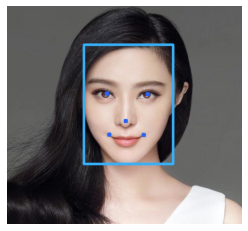

In [9]:
from src.utils import preprocess, drawPreds

# 循环加载所有的图片
for i, image_path in enumerate(test_dataset):

    # 加载图片
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = np.float32(img_raw)

    # 获取图片尺寸，计算resize的比例系数
    im_size_min = np.min(img.shape[0:2])
    im_size_max = np.max(img.shape[0:2])
    resize = float(target_size) / float(im_size_min)

    # 以图片较长的边进行resize，规范化图片尺寸
    if np.round(resize * im_size_max) > max_size:
        resize = float(max_size) / float(im_size_max)
    img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
    assert img.shape[0] <= max_size and img.shape[1] <= max_size

    # 以固定数值填充图像，补充成640*640的正方形图像
    image_t = np.empty((max_size, max_size, 3), dtype=img.dtype)
    image_t[:, :] = (104.0, 117.0, 123.0)
    image_t[0:img.shape[0], 0:img.shape[1]] = img
    img = image_t

    # 实例化解码模型输出时需要的参数
    scale = np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)
    ldm_scale = np.array(
        [img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1],
         img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)

    # 数据预处理
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = Tensor(img)  # [1, c, h, w]

    # 模型验证
    timers['forward_time'].start()
    boxes, confs, ldm = net(img)  # forward pass
    timers['forward_time'].end()

    # 模型输出解码，将输出的三个矩阵解码为最终的结果
    # box的坐标，以及landmark的坐标值
    timers['misc'].start()
    img_name = image_path.split('\\')[-1]
    detection.detect(boxes, ldm, confs, resize, scale, ldm_scale, img_name, priors)
    timers['misc'].end()

    print('im_detect: {:d} forward_pass_time: {:.4f}s misc: {:.4f}s'.format(i + 1,
                                                                            timers['forward_time'].diff,
                                                                            timers['misc'].diff))
print('Predict box done.')
print('Draw image starting')

# 获取推理结果
pred_file = detection.results['input_image']
save_base_path = draw_save_folder

# 遍历推理结果
for img_name in pred_file:
    # 获取图片路径和保存路径
    input_path = os.path.join(img_folder, img_name + '.jpg')
    save_path = os.path.join(save_base_path, img_name + '.jpg')
    bbox_to_draw = []
    landmark_to_draw = []

    # 对landmark进行解析
    processed_landmark = preprocess(pred_file[img_name]['landmarks'])

    # 加载box框结果然后画图
    for i, j in enumerate(pred_file[img_name]['bboxes']):
        x, y, width, height, conf = j
        if conf > conf_threshold:
            bbox_to_draw.append([int(x), int(y), int(width), int(height), conf])
            landmark_to_draw.append(processed_landmark[i])
    length_box = len(bbox_to_draw)
    if length_box < 1:
        continue

    # 读取原始图片并画图
    frame = cv2.imread(input_path)
    img_det = drawPreds(frame, bbox_to_draw, landmark_list=processed_landmark)
    cv2.imwrite(save_path, img_det)
print('Draw image done.')

# 加载一张推理图片展示效果
img_show_path = os.path.join(save_base_path, list(pred_file.keys())[0] + '.jpg')
img_show = cv2.imread(img_show_path)

plt.plot()
plt.imshow(img_show[:, :, [2, 1, 0]])
plt.axis(False)
plt.show()

## 总结

本案例完整复现了RetinaFace网络的训练，验证和推理过程，也深入讲解了网络中的关键结构，如：FPN，anchor结构等。通过深入学习本案例，用户将深入了解RetinaFace网络的架构，理解网络的原理。通过自己调试代码中的关键参数，可以更好的帮助用户理解RetinaFace的核心要义。

## 引用

[1] Deng J ,  Guo J ,  Zhou Y , et al. RetinaFace: Single-stage Dense Face Localisation in the Wild[J].  2019.